### Download outputs from wandb

In [2]:
import wandb
from tqdm import tqdm

project = "plancraft"
entity = "itl"

api = wandb.Api()
runs = api.runs(f"{entity}/{project}")

# download all 
for run in tqdm(runs):
    for file in run.files():
        if (
            file.name.startswith("outputs/")
            and file.name.endswith(".json")
            and "/val.small/" in file.name
        ):
            file.download(exist_ok=True)

100%|██████████| 93/93 [32:40<00:00, 21.08s/it]


### Collate outputs into single results

In [1]:
import glob
import json

# load from local
task_results = glob.glob("outputs/*/val.small/*/*.json")
results = []

for task_result in task_results:
    example_id = task_result.split("/")[-1]
    seed = task_result.split("/")[-2]
    split = task_result.split("/")[-3]
    run_name = task_result.split("/")[-4]
    with open(task_result) as f:
        result = json.load(f)

    result["name"] = run_name
    result["split"] = split
    result["seed"] = seed

    results.append(result)

In [2]:
with open("data/val.small.json", "r") as f:
    val_small = json.load(f)
    valid_id_set = set([x["id"] for x in val_small])

In [3]:
example_id_to_complexity_bin = {v["id"]: int(v["complexity_bin"]) for v in  val_small}

In [301]:
import pandas as pd


df = pd.DataFrame(results)
# df.model_trace.apply(pd.Series)
df = pd.concat([df, df.model_trace.apply(pd.Series)], axis=1).drop(
    "model_trace", axis=1    
)
# ensure only ids in the val.small are included
df = df[df["example_id"].isin(valid_id_set)]
# only include runs with all ids in the val.small
df = df.groupby(["name", "seed"]).filter(lambda x: len(x) == len(valid_id_set))

df["name"] = df["name"].str.replace("Meta-Llama-3.1-8B-Instruct", "Llama_8B")
df["name"] = df["name"].str.replace("Meta-Llama-3.1-70B-Instruct", "Llama_70B")
df["name"] = df["name"].str.replace("Meta-Llama-3.1-70B-Instruct", "Llama_70B")
df["name"] = df["name"].str.replace("oa-llama3-r64-a32", "Llama_8B_FT")
# df["name"] = df["name"].str.replace("_symb", "")
df["tools"] = df["name"].str.split("_").str[-1]
df["mode"] = df["name"].str.split("_").str[0]
df["modality"] = df["name"].str.split("_").str[1]
df["model"] = df["name"].str.split("_").str[2:-1].str.join("_")


def get_impossible(x):
    # Whether or not the last element in the dialogue history is impossible
    if len(x) == 0:
        return False
    last_element = x[-1]["content"]
    if isinstance(last_element, list):
        last_element = last_element[-1]["text"]
    return last_element.startswith("impossible:")


def multimodal_dialogue(x):
    # Multimodal dialogue wraps content response in a list [{type: "text", text: "response"}]
    if len(x) == 0:
        return False
    if isinstance(x[-1]["content"], list):
        return True
    return False


df["multimodal_dialogue"] = df["dialogue_history"].apply(multimodal_dialogue)
df["impossible_emitted"] = df["dialogue_history"].apply(get_impossible)
df["complexity_bin"] = df["example_id"].apply(lambda x: example_id_to_complexity_bin[x])

complexity_bins_names = {
    0: "easy",
    1: "easy",
    2: "medium",
    3: "hard",
    4: "hard",
    5: "other",
}
df["original_complexity_bin"] = df["complexity_bin"]
df["complexity_bin"] = df["complexity_bin"].map(complexity_bins_names)

# Count actions
def count_actions(dialogue):
    actions = {
        "move": 0,
        "smelt": 0,
        "think": 0,
        "impossible": 0,
        "search": 0,
        "invalid": 0,
    }
    for message in dialogue:
        if message["role"] == "assistant":
            if isinstance(message["content"], list):
                for content in message["content"]:
                    if content["type"] != "text":
                        continue
                    action = content["text"].split(":")[0]
                    if action not in actions:
                        actions["invalid"] += 1
                    else:
                        actions[action] += 1
                    break
            else:
                action = message["content"].split(":")[0]
                if action not in actions:
                    actions["invalid"] += 1
                else:
                    actions[action] += 1
    # rename actions to action_counts
    out_dict = {f"{k}_count": v for k, v in actions.items()}
    out_dict["total_actions"] = sum(actions.values())
    return out_dict


# count number of actions for oracle
def oracle_count(action_history):
    actions_count = {
        "move_count": 0,
        "smelt_count": 0,
        "impossible_count": 0,
        "search_count": 0,
        "think_count": 0,
    }
    if len(action_history) == 0:
        actions_count["impossible_count"] = 1
        actions_count["total_actions"] = sum(actions_count.values())
        return actions_count
    for action in action_history:
        action_type = action["action_type"]
        actions_count[f"{action_type}_count"] += 1

    actions_count["total_actions"] = sum(actions_count.values())

    return actions_count


df["actions_dict"] = df["dialogue_history"].apply(count_actions)
df.loc[df["mode"] == "oracle", "actions_dict"] = df[df["mode"] == "oracle"][
    "action_history"
].apply(oracle_count)

df = pd.concat([df, df.actions_dict.apply(pd.Series)], axis=1).drop(
    "actions_dict", axis=1
)

# df["impossible_accuracy"] = df["impossible_emitted"] == df["impossible"]

# get dict mapping betwwen example_id and the oracle's total_actions
oracle_actions = (
    df[df["mode"] == "oracle"].groupby("example_id")["total_actions"].first().to_dict()
)
df["oracle_length"] = df["example_id"].map(oracle_actions)


In [302]:
# df[df["total_actions"]]
df["tokens_used"].median()

2593274.5

### Results Table for Success

In [303]:
# df.groupby("example_id")
# succ_df = df[df["success"]]

# succ_df["total_actions"](succ_df["total_actions"] - succ_df["oracle_length"]).describe()
# df["total_actions"] = df["move_count"] + df["smelt_count"] + df["impossible_count"] + df["search_count"] + df["think_count"]
df.loc[(df["mode"] != "oracle")&df["success"], "actions_over_oracle"] = df.loc[(df["mode"] != "oracle")&df["success"], "total_actions"] - df.loc[(df["mode"] != "oracle")&df["success"], "oracle_length"]

df.actions_over_oracle.describe()
# df[df["actions_over_oracle"] < 0]


count    1674.000000
mean        2.453405
std         3.565196
min         0.000000
25%         0.000000
50%         2.000000
75%         3.000000
max        28.000000
Name: actions_over_oracle, dtype: float64

In [ ]:
df[
    (df["mode"] != "oracle")
    & (df["complexity_bin"] != "other")
    & (df["mode"] == "act")
    & (df["modality"] == "symb")
]


In [343]:
# calculate f1 score for impossible
from sklearn.metrics import f1_score


df_pivot = (
    df[df["mode"] != "oracle"]
    # .groupby(["modality", "model", "mode", "tools", "recipe_type"])
    .groupby(["modality", "model", "mode", "tools", "complexity_bin"])
    .success.mean()
    .unstack(level=-1)
    .reset_index()
)

# concat with grouped by counts of actions
df_pivot = pd.merge(
    df_pivot,
    df[
        (df["mode"] != "oracle")
        & (df["complexity_bin"] != "other")
        & (df["mode"] == "act")
        # & (df["modality"] == "symb")
    ]
    .groupby(["modality", "model", "mode", "tools"])
    .agg(
        {
            "total_actions": "mean",
            "move_count": "mean",
            "smelt_count": "mean",
            "think_count": "mean",
            "impossible_count": "mean",
            "search_count": "mean",
            "invalid_count": "mean",
            "actions_over_oracle": "mean",
            "tokens_used": "mean",
        }
    )
    .reset_index(),
    on=["modality", "model", "mode", "tools"],
    how="left",
)

# add f1 score for impossible
df_pivot = pd.merge(
    df_pivot,
    df[df["tools"].str.contains("impossible")]
    .groupby(["modality", "model", "mode", "tools"])
    .apply(
        lambda x: f1_score(x["impossible"], x["impossible_emitted"]),
        # include_groups=False,
    )
    .reset_index(),
    on=["modality", "model", "mode", "tools"],
    how="left",
)
df_pivot.rename(columns={0: "impossible f1"}, inplace=True)



# df_pivot["overall"] = df_pivot[["mixed", "shaped", "shapeless", "smelting"]].mean(
#     axis=1
# )
# df_pivot["overall"] = df_pivot[
#     ["very easy", "easy", "medium", "hard", "very hard"]
# ].mean(axis=1)
# df_pivot["overall"] = df_pivot[
#     [ "easy", "medium", "hard"]
# ].mean(axis=1)
# overall success
overall_success_df = (
    df[
        (df["mode"] != "oracle")
        & (df["complexity_bin"] != "other")
        & (df["mode"] == "act")
        # & (df["modality"] == "symb")
    ]
    .groupby(["modality", "model", "mode", "tools"])
    .success.mean()
    .reset_index()
)

# add into the pivot table
df_pivot = pd.merge(
    df_pivot,
    overall_success_df,
    on=["modality", "model", "mode", "tools"],
    how="left",
)

# rename success to overall
df_pivot.rename(columns={"success": "overall"}, inplace=True)
# rename models to be more human readable
df_pivot["model"] = df_pivot["model"].str.replace("_", " ")

# group by modality then tools then model and sort by overall
df_pivot = df_pivot.sort_values(
    ["modality", "tools", "model", "overall"], ascending=[True, True, False, False]
)

# Replace NaN with "-"
df_pivot["impossible f1"] = df_pivot["impossible f1"].fillna("-")


# Find the maximum value in the "overall" column
max_overall = df_pivot["overall"].max()
print(max_overall)
# Apply the bolding to the 'overall' column
def bold_max(s):
    return "\\textbf{%s}" % s if s == f"{max_overall:.2f}" else s
# Apply the function to the 'overall' column
df_pivot["overall"] = df_pivot["overall"].apply(
    lambda x: bold_max(f"{x:.2f}")
)

df_pivot = df_pivot[df_pivot["mode"] == "act"]
# df_pivot = df_pivot[df_pivot["modality"] == "symb"]


tools_to_acronym = {
    "move|smelt": "M S",
    "move|smelt|think": "M S T",
    "move|smelt|think|search": "M S T SE",
    "move|smelt|think|search|impossible": "M S T SE I",
}

df_pivot["tools"] = df_pivot["tools"].map(tools_to_acronym)


# title case column names
df_pivot.columns = [x.title().replace("_", " ") for x in df_pivot.columns]


# Columns to underline the max values
columns_to_format = ["Easy", "Medium", "Hard"]
# Group by 'Tools' and format max values
for col in columns_to_format:
    max_indices = df_pivot.groupby("Tools")[col].transform("max") == df_pivot[col]
    df_pivot.loc[max_indices, col] = df_pivot.loc[max_indices, col].apply(
        lambda x: f"\\underline{{{x:.2f}}}"
    )
df_pivot["Think Count"].replace(0, "-", inplace=True)
df_pivot["Search Count"].replace(0, "-", inplace=True)
df_pivot["Impossible Count"].replace(0, "-", inplace=True)


def format_thousands(x):
    if x >= 1_000_000:
        return f"{x/1_000_000:.1f}M"
    elif x >= 1_000:
        return f"{x/1_000:.1f}k"
    else:
        return f"{x}"
    
df_pivot["Tokens Used"] = df_pivot["Tokens Used"].apply(format_thousands)

# rename columns to remove "Count"
df_pivot.rename(
    columns={
        "Move Count": "Move",
        "Smelt Count": "Smelt",
        "Think Count": "Think",
        "Impossible Count": "Impossible",
        "Search Count": "Search",
        "Invalid Count": "Invalid",
        "Actions Over Oracle": "AE", # Action efficiency
        "Total Actions": "Avg. Plan Length",
    },
    inplace=True,
)

print(df_pivot["Model"].unique())
model_order = [
    "Llama 8B",
    "Llama 70B",
    "gpt-4o-mini",
    "Llama 8B FT",
    "oam-llama3-r64-a32",
    "mrcnn gpt-4o-mini",
]

# Convert the Model column to a categorical type with the specified order
df_pivot["Model"] = pd.Categorical(
    df_pivot["Model"], categories=model_order, ordered=True
)

# Sort by Tools (ascending) and Model (following the categorical order)
df_pivot = df_pivot.sort_values(
    ["Tools", "Model"],
    ascending=[True, True],  # True for Tools, categorical handles Model order
)

symb_table = df_pivot[df_pivot["Modality"] == "symb"]

print(
    symb_table[
        [
            # "modality",
            "Tools",
            "Model",
            # "mode",
            # "mixed",
            # "shaped",
            # "shapeless",
            # "smelting",
            # "very easy",
            "Easy",
            "Medium",
            "Hard",
            # "very hard",
            "Overall",
            "Think",
            "Search",
            "Impossible",
            "Impossible F1",
            "Avg. Plan Length",
            "AE",
            "Tokens Used",
            # "Invalid Count",
        ]
    ].to_latex(index=False, float_format="%.2f", escape=False)
)
symb_table

0.6222222222222222
['oam-llama3-r64-a32' 'mrcnn gpt-4o-mini' 'Llama 8B' 'Llama 70B'
 'gpt-4o-mini' 'Llama 8B FT']
\begin{tabular}{llllllllllrrl}
\toprule
Tools & Model & Easy & Medium & Hard & Overall & Think & Search & Impossible & Impossible F1 & Avg. Plan Length & AE & Tokens Used \\
\midrule
M S & Llama 8B & 0.12 & 0.00 & 0.00 & 0.06 & - & - & - & - & 12.93 & 0.80 & 1.0M \\
M S & Llama 70B & 0.42 & 0.20 & 0.00 & 0.23 & - & - & - & - & 12.74 & 0.52 & 2.4M \\
M S & gpt-4o-mini & 0.33 & 0.05 & 0.00 & 0.16 & - & - & - & - & 13.04 & 0.07 & 732.2k \\
M S & Llama 8B FT & \underline{0.73} & \underline{0.72} & \underline{0.04} & 0.50 & - & - & - & - & 9.77 & 0.16 & 2.4M \\
M S T & Llama 8B & 0.17 & 0.00 & 0.00 & 0.08 & 8.82 & - & - & - & 21.54 & 3.86 & 1.7M \\
M S T & Llama 70B & 0.59 & 0.45 & 0.00 & 0.36 & 6.20 & - & - & - & 16.10 & 3.82 & 4.4M \\
M S T & gpt-4o-mini & 0.40 & 0.20 & 0.00 & 0.22 & 13.71 & - & - & - & 22.01 & 4.20 & 1.5M \\
M S T & Llama 8B FT & \underline{0.70} & \underline

/var/folders/v9/d_dqlnbx7vl__wmp0ymbq2m80000gn/T/ipykernel_7104/2145019329.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['\\underline{0.73}' '\\underline{0.70}' '\\underline{0.89}'
 '\\underline{0.87}']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_pivot.loc[max_indices, col] = df_pivot.loc[max_indices, col].apply(
/var/folders/v9/d_dqlnbx7vl__wmp0ymbq2m80000gn/T/ipykernel_7104/2145019329.py:137: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['\\underline{0.72}' '\\underline{0.73}' '\\underline{0.72}'
 '\\underline{0.82}']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_pivot.loc[max_indices, col] = df_pivot.loc[max_indices, col].apply(
/var/folders/v9/d_dqlnbx7vl__wmp0ymbq2m80000gn/T/ipykernel_7104/2145019329.py:137: FutureWarning: Setting 

,Modality,Model,Mode,Tools,Easy,Hard,Medium,Other,Avg. Plan Length,Move,Smelt,Think,Impossible,Search,Invalid,AE,Tokens Used,Impossible F1,Overall
13,symb,Llama 8B,act,M S,0.125,0.0,0.0,0.000000,12.933333,12.088889,0.133333,-,-,-,0.711111,0.800000,1.0M,-,0.06
9,symb,Llama 70B,act,M S,0.425,0.0,0.2,0.000000,12.744444,11.238889,0.088889,-,-,-,1.416667,0.523810,2.4M,-,0.23
25,symb,gpt-4o-mini,act,M S,0.325,0.0,0.05,0.000000,13.044444,12.166667,0.133333,-,-,-,0.744444,0.071429,732.2k,-,0.16
21,symb,Llama 8B FT,act,M S,\underline{0.73},\underline{0.04},\underline{0.72},0.000000,9.774074,8.911111,0.844444,-,-,-,0.018519,0.162963,2.4M,-,0.50
14,symb,Llama 8B,act,M S T,0.175,0.0,0.0,0.000000,21.544444,12.133333,0.444444,8.822222,-,-,0.144444,3.857143,1.7M,-,0.08
10,symb,Llama 70B,act,M S T,0.591667,0.0,0.45,0.000000,16.103704,9.725926,0.162963,6.196296,-,-,0.018519,3.816327,4.4M,-,0.36
26,symb,gpt-4o-mini,act,M S T,0.4,0.0,0.2,0.000000,22.011111,8.111111,0.177778,13.711111,-,-,0.011111,4.200000,1.5M,-,0.22
22,symb,Llama 8B FT,act,M S T,\underline{0.70},\underline{0.02},\underline{0.73},0.000000,9.451852,9.144444,0.240741,0.062963,-,-,0.003704,0.207692,2.4M,-,0.48
15,symb,Llama 8B,act,M S T SE,0.775,0.0,0.25,0.000000,15.555556,9.022222,0.288889,3.277778,-,2.755556,0.211111,2.666667,968.6k,-,0.40
11,symb,Llama 70B,act,M S T SE,\underline{0.89},\underline{0.25},0.65,0.000000,14.522222,9.605556,0.222222,3.15,-,1.505556,0.038889,3.116071,6.2M,-,\textbf{0.62}


In [350]:
real_table = df_pivot[(df_pivot["Modality"] == "real")&(df_pivot["Tools"] == "M S")]

print(
    real_table[
        [
            # "modality",
            # "Tools",
            "Model",
            # "mode",
            # "mixed",
            # "shaped",
            # "shapeless",
            # "smelting",
            # "very easy",
            # "Easy",
            # "Medium",
            # "Hard",
            # "very hard",
            "Overall",
            # "Think",
            # "Search",
            # "Impossible",
            # "Impossible F1",
            "Avg. Plan Length",
            "AE",
            "Tokens Used",
            # "Invalid Count",
        ]
    ].to_latex(index=False, float_format="%.2f", escape=False)
)


\begin{tabular}{llrrl}
\toprule
Model & Overall & Avg. Plan Length & AE & Tokens Used \\
\midrule
Llama 8B & 0.04 & 14.08 & 0.50 & 3.9M \\
Llama 70B & 0.24 & 12.36 & 0.67 & 3.3M \\
oam-llama3-r64-a32 & 0.00 & 11.77 & 5.00 & 31.2k \\
mrcnn gpt-4o-mini & 0.08 & 17.11 & 0.00 & 6.8M \\
\bottomrule
\end{tabular}



In [352]:
df["tools"]

0                               move|smelt
1                               move|smelt
2                               move|smelt
3                               move|smelt
4                               move|smelt
                       ...                
6742    move|smelt|think|search|impossible
6743    move|smelt|think|search|impossible
6744    move|smelt|think|search|impossible
6745    move|smelt|think|search|impossible
6746    move|smelt|think|search|impossible
Name: tools, Length: 6270, dtype: object

### Results Table for Plan Length

In [207]:
id_to_steps = df[df["mode"] == "oracle"][["example_id", "number_of_steps"]].set_index("example_id").to_dict()["number_of_steps"]
# calculate steps diff between oracle and model
df["oracle_steps"] = df["example_id"].map(id_to_steps)
df["steps_diff"] = df["number_of_steps"] - df["oracle_steps"]
df.loc[~df["success"], "steps_diff"] = 10

In [211]:
df_pivot = (
    df[df["mode"] != "oracle"]
    .groupby(["modality", "model", "mode", "tools", "recipe_type"])
    .steps_diff.mean()
    .unstack(level=-1)
    .reset_index()
)
df_pivot["overall"] = df_pivot[["mixed", "shaped", "shapeless", "smelting"]].mean(axis=1)
df_pivot["model"] = df_pivot["model"].str.replace("_", " ")

df_pivot = df_pivot.sort_values(
    ["modality", "tools", "model", "overall"], ascending=[True, True, False, False]
)

# bolden min values for overall column
min_overall = df_pivot["overall"].min()

def bold_min(s):
    return "\\textbf{%s}" % s if s == f"{min_overall:.2f}" else s

df_pivot["overall"] = df_pivot["overall"].apply(
    lambda x: bold_min(f"{x:.2f}")
)

# in impossible column, if 10 then replace with "-"
df_pivot["impossible"] = df_pivot["impossible"].apply(lambda x: "-" if x == 10 else x)

print(
    df_pivot[
        [
            "mode",
            "tools",
            "model",
            "mixed",
            "shaped",
            "shapeless",
            "smelting",
            "overall",
            "impossible",
        ]
    ].to_latex(index=False, float_format="%.2f")
)


\begin{tabular}{lllrrrrll}
\toprule
mode & tools & model & mixed & shaped & shapeless & smelting & overall & impossible \\
\midrule
act & move|smelt & gpt-4o-mini & 10.00 & 10.00 & 10.00 & 10.00 & 10.00 & - \\
act & move|smelt & Llama 8B & 9.60 & 9.84 & 9.22 & 8.20 & 9.22 & - \\
act & move|smelt & Llama 70B & 8.84 & 8.50 & 5.86 & 2.40 & 6.40 & - \\
act & move|smelt|think & Llama 8B & 9.61 & 9.82 & 8.61 & 8.13 & 9.04 & - \\
act & move|smelt|think & Llama 70B & 8.29 & 7.08 & 5.69 & 2.00 & 5.76 & - \\
act & move|smelt|think|search & Llama 8B & 9.37 & 6.87 & 5.55 & 3.47 & 6.31 & - \\
act & move|smelt|think|search & Llama 70B & 7.60 & 3.77 & 4.06 & 2.00 & 4.36 & - \\
act & move|smelt|think|search|impossible & Llama 8B & 9.19 & 7.83 & 6.59 & 4.67 & 7.07 & 3.70 \\
act & move|smelt & gpt-4o-mini & 9.24 & 9.77 & 5.88 & 2.00 & 6.72 & - \\
act & move|smelt & Llama 8B Finetuned & 7.15 & 5.24 & 3.14 & 0.00 & 3.88 & - \\
react & move|smelt & Llama 8B & 9.60 & 9.58 & 9.06 & 8.80 & 9.26 & - \\
act & m

### token used table

In [231]:
def format_thousands(x):
    if x >= 1_000_000:
        return f"{x/1_000_000:.1f}M"
    elif x >= 1_000:
        return f"{x/1_000:.1f}k"
    else:
        return f"{x}"

df_pivot = (
    df.groupby(["modality", "model", "mode", "tools", "recipe_type"])
    .tokens_used.mean()
    .unstack(level=-1)
    .reset_index()
)

df_pivot["overall"] = df_pivot[["mixed", "shaped", "shapeless", "smelting"]].mean(axis=1)

# Apply the formatting to the DataFrame before exporting to LaTeX
formatted_df = df_pivot[
    [
        "tools",
        "mode",
        "model",
        "mixed",
        "shaped",
        "shapeless",
        "smelting",
        "overall",
        "impossible",
    ]
].copy()
for col in ["mixed", "shaped", "shapeless", "smelting", "overall", "impossible"]:
    formatted_df[col] = formatted_df[col].apply(format_thousands)

# Export to LaTeX
print(formatted_df.to_latex(index=False))


\begin{tabular}{lllllllll}
\toprule
tools & mode & model & mixed & shaped & shapeless & smelting & overall & impossible \\
\midrule
move|smelt & act & Llama_70B & 3.8M & 3.2M & 3.1M & 2.5M & 3.2M & 4.7M \\
move|smelt|think & act & Llama_70B & 5.0M & 4.3M & 4.1M & 3.4M & 4.2M & 6.3M \\
move|smelt|think|search & act & Llama_70B & 1.6M & 798.6k & 720.2k & 72.1k & 799.7k & 3.0M \\
move|smelt & act & Llama_8B & 4.4M & 3.8M & 3.7M & 3.0M & 3.7M & 5.3M \\
move|smelt|think & act & Llama_8B & 6.4M & 5.4M & 5.2M & 4.2M & 5.3M & 7.6M \\
move|smelt|think|search & act & Llama_8B & 3.4M & 2.5M & 2.8M & 3.4M & 3.0M & 4.6M \\
move|smelt|think|search|impossible & act & Llama_8B & 2.8M & 2.3M & 2.3M & 1.8M & 2.3M & 3.4M \\
move|smelt & act & gpt-4o-mini & 9.2M & 5.7M & 5.0M & 1.1M & 5.2M & 13.9M \\
symb & oracle &  & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
move|smelt & act & Llama_70B & 2.5M & 1.8M & 1.7M & 1.5M & 1.9M & 3.6M \\
move|smelt|think & act & Llama_70B & 5.1M & 4.3M & 4.1M & 3.4M & 4.2M & 6.5M \

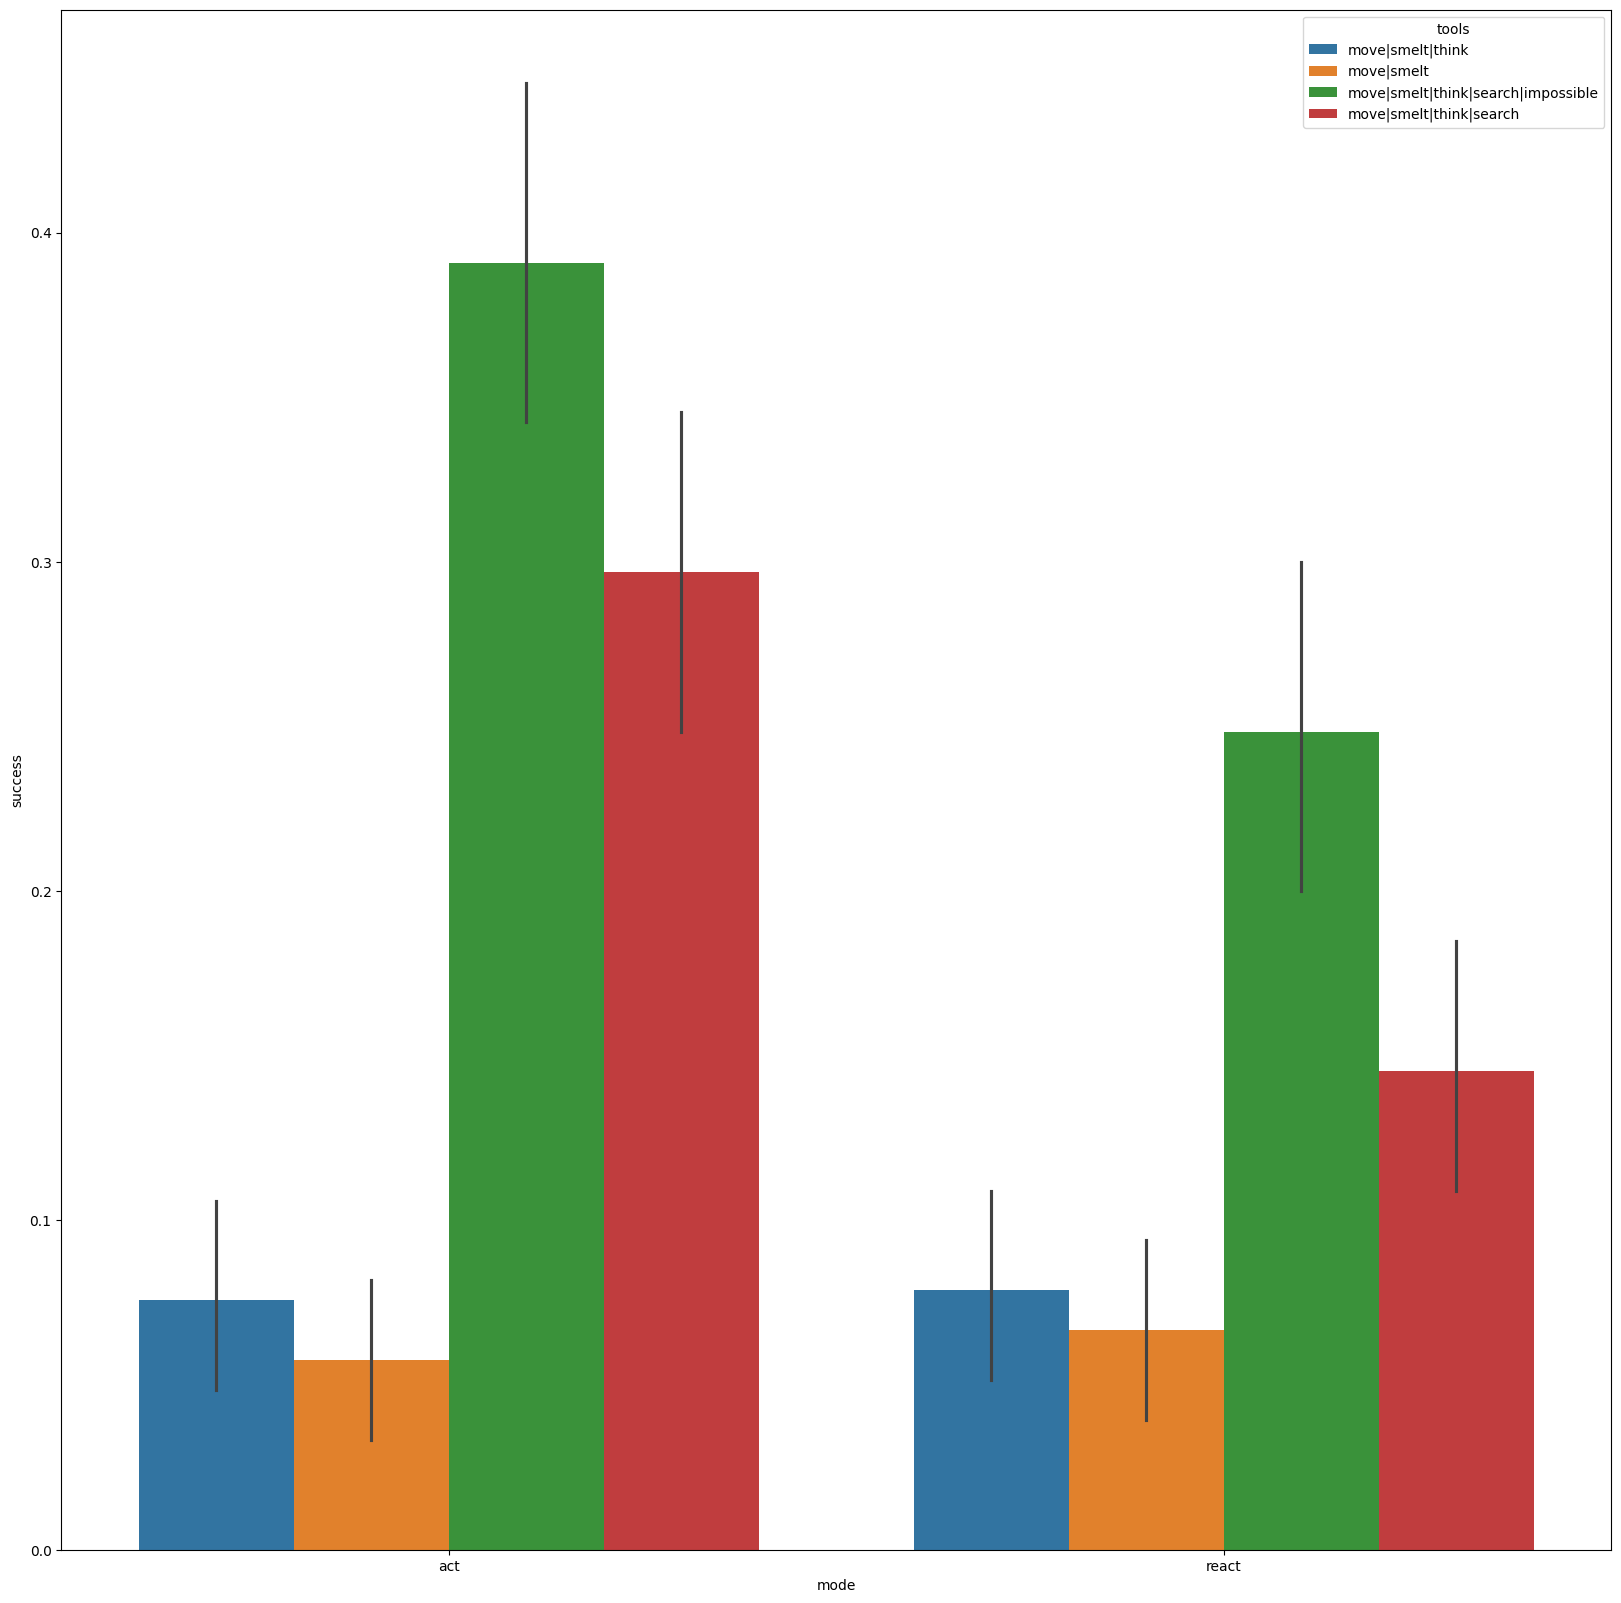

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(data=df, x="mode", y="success", hue="tools")
# rotate x labels
# plt.xticks(rotation=45)
plt.show()
